# A time Story of offshore Societies

You can see the aim of this project in the README file.

Our work is based on 4 databases, namely the *bahamas leaks*, the *panama papers*, the *offshore leaks* and the *paradise papers*. They all contain csv files with all the data of a graph : nodes (one file for each type of node), and edges. We merged all these files in this notebook.

You will see all the steps of our data exploration. In the end our objective is to arrive to two Dataframe, one containing all the nodes and the relevant information, and one containing the edges with relevant information.

## Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx #For graphs
import copy
import warnings
from datetime import *
import dateutil.parser
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# https://www.occrp.org/en/panamapapers/database
# TRUMP OFFSHORE INC. is good example to see all entities interacting

## Filenames / paths

The data is separated for every leak source. For each leak source there is a folder containing the nodes of the graph, that can be of different types : <i>intermediary, officer, entity, address</i> (and <i>other</i> for paradise papers only). The folder also contains the edges of this graph.

In [2]:
bahamas_folder = "bahamas/"
panama_folder = "panama/"
paradise_folder = "paradise/"
offshore_folder = "offshore/"

sources_names = ['bahamas', 'panama', 'paradise', 'offshore']

panama_name = panama_folder + "panama_papers"
paradise_name = paradise_folder + "paradise_papers"
offshore_name = offshore_folder + "offshore_leaks"
bahamas_name = bahamas_folder + "bahamas_leaks"

edges_name = ".edges"
nodes_name = ".nodes."

address_name = "address"
intermediary_name = "intermediary"
officer_name = "officer"
entity_name = "entity"
others_name = "other" # Only for paradise paper there is this extra entity

usual_entity_names = [address_name, intermediary_name, officer_name, entity_name]

## Build local storage

We store data in dictionnaries that map each leak source to its content, which is a dictionnary that maps each type of entity to the Dataframe containing its values. For example <b>d_sources["bahamas"]["officer"]</b> is the Dataframe of officers coming from the bahamas leaks.

In [3]:
def my_read_csv(filename) :
    """ To have same rules when reading data from csv """
    return pd.read_csv(filename, dtype = str)

def build_dict(source_name):
    """
    Create a dictionnary for a certain source_name (among : Panama papers, Paradise papers...)
    that maps to each entity name (among : Officer, Intermediary, Address...)
    the content of the csv from source_name for this entity
    """
    d = {en : my_read_csv(source_name + nodes_name + en + ".csv") for en in usual_entity_names}
    
    if source_name == paradise_name: # Extra "other" entity in paradise papers
        d[others_name] = my_read_csv(source_name + nodes_name + others_name + ".csv")
    
    #Add edges
    d["edges"] = my_read_csv(source_name + edges_name + ".csv")
              
    return d

Build the dictionnary, that maps each source to its content

In [4]:
d_sources = dict()
d_sources["bahamas"] = build_dict(bahamas_name)
d_sources["panama"] = build_dict(panama_name)
d_sources["paradise"] = build_dict(paradise_name)
d_sources["offshore"] = build_dict(offshore_name)

In [5]:
d_sources['panama']['entity'].columns

Index(['node_id', 'name', 'jurisdiction', 'jurisdiction_description',
       'country_codes', 'countries', 'incorporation_date', 'inactivation_date',
       'struck_off_date', 'closed_date', 'ibcRUC', 'status', 'company_type',
       'service_provider', 'sourceID', 'valid_until', 'note'],
      dtype='object')

## Getting familiar with the data format

### Define some coloring for printing

Keep the same coloring during the project, it makes data very easily readable once you get familiar with the coloring !

In [6]:
BOLD = '\033[1m'
BLUE = '\033[94m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RED = '\033[91m'
END = '\033[0m'

color_dict = dict()
color_dict["bahamas"] = YELLOW
color_dict["paradise"] = GREEN
color_dict["panama"] = RED
color_dict["offshore"] = BLUE

def color(str):
    """
    Returns the str given in the color of the source it is from 
    (the str must contain source name)
    """
    for source in color_dict.keys():
        if source in str:
            return color_dict[source] + str + END 
        
    return BOLD + str + END #Default color is BOLD

for name, _ in color_dict.items():
    print(color(name))
print(color("Unknown source"))

bahamas
paradise
panama
offshore
Unknown source


### See what data source misses which column

In [7]:
for source, dict_data in d_sources.items():
    for source_compare, dict_data_compare in d_sources.items():
        print("\n", color(source_compare), "missing columns from source :", color(source))
        for entity in usual_entity_names:
            missing_columns = []
            for col in dict_data[entity].columns:
                if not col in dict_data_compare[entity].columns:
                    missing_columns.append(col)
            if(len(missing_columns) > 0):
                print("Node type", entity, "misses", len(missing_columns), "columns, namely : ", missing_columns)



 bahamas missing columns from source : bahamas

 panama missing columns from source : bahamas
Node type address misses 10 columns, namely :  ['labels(n)', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'incorporation_date', 'ibcRUC', 'type', 'status', 'company_type']
Node type intermediary misses 10 columns, namely :  ['labels(n)', 'address', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'incorporation_date', 'ibcRUC', 'type', 'company_type']
Node type officer misses 11 columns, namely :  ['labels(n)', 'address', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'incorporation_date', 'ibcRUC', 'type', 'status', 'company_type']
Node type entity misses 3 columns, namely :  ['labels(n)', 'address', 'type']

 paradise missing columns from source : bahamas
Node type address misses 10 columns, namely :  ['labels(n)', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'in

We see that <span style="color:orange">bahamas</span> is the most "complete" source, in the sense it is the one that has the biggest number of columns missing in the others. We will therefore use it to explore the content of columns. *'inactivation_date'* and  *'struck_off_date'* columns from entity will then be explored in <span style="color:red">panama</span>

#### Special case : Paradise paper, <i>other</i> node

In [8]:
d_sources["paradise"]["other"].columns

Index(['node_id', 'name', 'country_codes', 'countries', 'sourceID',
       'valid_until', 'note'],
      dtype='object')

### SourceID in different sources

We see paradise papers is the only source that has different sourceID

In [9]:
for source, dict_data in d_sources.items():
    print("\nSource :", color(source))
    for entity in usual_entity_names:
        value_count =  dict_data[entity]["sourceID"].value_counts()
        print("Node :", entity, len(value_count), "different sourceID :")


Source : bahamas
Node : address 1 different sourceID :
Node : intermediary 1 different sourceID :
Node : officer 1 different sourceID :
Node : entity 1 different sourceID :

Source : panama
Node : address 1 different sourceID :
Node : intermediary 1 different sourceID :
Node : officer 1 different sourceID :
Node : entity 1 different sourceID :

Source : paradise
Node : address 7 different sourceID :
Node : intermediary 5 different sourceID :
Node : officer 9 different sourceID :
Node : entity 9 different sourceID :

Source : offshore
Node : address 1 different sourceID :
Node : intermediary 1 different sourceID :
Node : officer 1 different sourceID :
Node : entity 1 different sourceID :


### Check if node_id is a good index for Nodes

In [10]:
merged_node_id = pd.Series()

for source, dict_data in d_sources.items():
    merged_node_id_source = pd.Series()
    for entity in usual_entity_names:
        
        merged_node_id_source = merged_node_id_source.append(dict_data[entity]["node_id"], ignore_index = True)
        
        if not dict_data[entity]["node_id"].is_unique:
            print("node_id isn't unique for source", color(source, "node", entity))
                  
    if not merged_node_id_source.is_unique:
        print("node_id isn't unique between nodes from source", color(source))
    
    merged_node_id = merged_node_id.append(merged_node_id_source.drop_duplicates())

if merged_node_id.is_unique:
    print("node_id is unique between unique nodes from all sources")

node_id isn't unique between nodes from source offshore
node_id is unique between unique nodes from all sources


So for each node type indepently node_id is a good index. Therefore (node_id, node_type) could be a good index (node_type being amond officer, intermediary...)

Now explore nodes with same node_id in offshore

In [11]:
for i in range(len(usual_entity_names)):
    for j in range(i+1, len(usual_entity_names)):

        left_node = usual_entity_names[i]
        node = usual_entity_names[j]
        print(color(left_node), color(node))
        
        if left_node != node:

            left = d_sources["offshore"][left_node].set_index("node_id")
            right = d_sources["offshore"][node].set_index("node_id")

            intersection = left.join(right, on = "node_id", how = 'inner', \
                                     lsuffix = "_" + left_node,rsuffix = "_" + node)

            if not intersection.empty:
                print("Intersection of", color(left_node), "and", color(node), "count is :")
                print(intersection.count())

address intermediary
address officer
address entity
intermediary officer
Intersection of intermediary and officer count is :
name_intermediary             1139
country_codes_intermediary    1139
countries_intermediary        1139
status                           0
sourceID_intermediary         1139
valid_until_intermediary      1139
note_intermediary                0
name_officer                  1139
country_codes_officer         1139
countries_officer             1139
sourceID_officer              1139
valid_until_officer           1139
note_officer                     0
dtype: int64
intermediary entity
officer entity


So the intersection on offshore is between officer and intermediary nodes. Let's see if they are the same values :

In [12]:
left = d_sources["offshore"]["officer"].set_index("node_id")
right = d_sources["offshore"]["intermediary"].set_index("node_id")

intersection = left.join(right, on = "node_id", how = 'inner', lsuffix = "_officer",rsuffix = "_interm")

intersection.loc[intersection["name_officer"] != intersection["name_interm"]].empty

True

Therefore we understand that if someone appears in two different node types, it means it is the same person, but has two roles. This is why in further analysis we will store the pair (node_id, role) as index, because it is unique. We have to add a column to nodes, containing the node type, let's call it label. We saw in the column exploration that bahamas has an equivalent column *labels(n)*, that the other's don't, we'll rename it to *label*

## Keep necessary columns, Shape data to our need

In [13]:
d_clean = dict()

#maps every node type to the columns to keep
d_columns = dict()
d_columns['address'] = ['country_codes', 'node_id']
d_columns['entity'] = ['node_id','name','jurisdiction','incorporation_date']
d_columns['intermediary'] = ['node_id', 'country_codes','name']
d_columns['officer'] = ['node_id', 'country_codes','name']
d_columns['other'] = ['node_id', 'country_codes','name']


for source, d in d_sources.items():
    
    d_clean[source] = dict()
    
    for node_type in usual_entity_names:
        d_clean[source][node_type] = d[node_type][d_columns[node_type]]
        d_clean[source][node_type]['source'] = source
        d_clean[source][node_type]['type'] = node_type
        d_clean[source][node_type]['node_id'] = d_clean[source][node_type]['node_id'].astype(np.int32)
    
    columns_edges = ['START_ID', 'END_ID', 'TYPE', 'start_date', 'end_date']        
    columns_edges_bahamas = ['node_1', 'node_2', 'rel_type', 'start_date', 'end_date']    
    
    if source == "bahamas": # adapt different column names
        d_clean[source]['edges'] = d_sources[source]['edges'][columns_edges_bahamas]
        d_clean[source]['edges'].columns = columns_edges
        
    else :
        d_clean[source]['edges'] = d_sources[source]['edges'][columns_edges]
    
    d_clean[source]['edges']['source'] = source
    d_clean[source]['edges']["START_ID"] = d_clean[source]['edges']["START_ID"].astype(np.int32)
    d_clean[source]['edges']["END_ID"] = d_clean[source]['edges']["END_ID"].astype(np.int32) 

d_clean['paradise']['other'] = d_sources['paradise']['other'][d_columns['other']]
d_clean["paradise"]['other']['source'] = 'paradise'
d_clean["paradise"]['other']['type'] = 'other'

### Create dictionaries for countries and jurisdictions

These dictionaries map the abrevation of countries to their full name, this way we can drop the longer column

In [14]:
countries = dict()
jurisdictions = dict()

for s in sources_names:
    for t in usual_entity_names:
        countries.update(dict(zip(d_sources[s][t]['country_codes'], d_sources[s][t]['countries'])))
        if t  == 'entity':
            jurisdictions.update(dict(zip(d_sources[s][t]['jurisdiction'], d_sources[s][t]['jurisdiction_description'])))
            
countries.update(dict(zip(d_sources['paradise']['other']['country_codes'],\
                          d_sources['paradise']['other']['countries'])))

## Create and study *node* dataframe

A pourcentage function to print pourcentages in a nice way

In [15]:
def pourcentage(n, precision = 2):
    """ To print a pourcentage in a nice way and with a given precision"""
    return color(("%." + str(precision) + "f") % (100.0*n) + "%")

A function to convert string of date to datetime format. There are a LOT of different string formats and we cover most of them. Dates with ambiguity such as 01/03/2001 are treated arbitrarily. (i.e. is this date 1st of March or 3rd of January ?) Indeed the year is generally what matters the most for us.

Years are valid until 2015 at most, and starting in the 1960s according to wikipedia (https://en.wikipedia.org/wiki/Panama_Papers)

When date is clearly an outlier (18/19/2006), it is set to NaN, and printed

In [16]:
def parse_date(date):
    """ Parsing of the date, read above for more details"""
    if (date==date):
        try:
            formatted = dateutil.parser.parse(date)
            if (formatted.year > 2015 or formatted.year < 1960):
                formatted = 'NaN'
            return formatted 
        except:
            print(date)
            return 'NaN'

### Node types that should contain NaN for each column name

Nodes can have NaN values because of missing data, <b>or</b> because the data doesn't make sense for this node type. You will here find a list of node types for each column, those are node types that are NaN because of this second reason. For example the jurisdiction for an Officer doesn't really make sense at first sight... We will however in the future try to cumpute all the jurisdictions an officer is related to using the edges (and many more)

##### name
- Address

##### jurisdiction and incorporation_date
- Officer
- Other
- Intermediary
- Address

##### country_codes
- Entity


In [17]:
nodes = pd.DataFrame(columns=['node_id','source','type','name','country_codes', 'jurisdiction', 'incorporation_date'])

for source,_ in d_sources.items():
    for node_type in usual_entity_names:
        nodes = nodes.append(d_clean[source][node_type], sort=False)
        
#nodes = nodes.append(d_clean['paradise']['other'], sort=False) # Uncomment to consider other nodes

nodes = nodes.astype({'node_id' : int})

nodes = nodes.set_index(['node_id', 'type'])

nodes['incorporation_date'] = nodes['incorporation_date'].apply(parse_date)
nodes['incorporation_date'] = pd.to_datetime(nodes['incorporation_date'])

nodes[nodes['country_codes'] == 'XXX'] = None
nodes[nodes['jurisdiction'] == 'XXX'] = None

In [18]:
nodes.describe()

source        name country_codes jurisdiction   incorporation_date
count    1813261     1438640        656715       731924               711888
unique         4     1176285          3570           79                15543
top     paradise  THE BEARER           CHN          BAH  1998-01-02 00:00:00
freq      864980       70871         69381       209634                 1335
first        NaN         NaN           NaN          NaN  1960-01-01 00:00:00
last         NaN         NaN           NaN          NaN  2015-12-31 00:00:00

It looks like there are a lot of unique country_codes... Indeed we notice some nodes have many country codes separated by a ';'

In [19]:
country_codes = nodes.country_codes.dropna()
number_multi_country = country_codes[country_codes.str.contains(";")].count()

print(pourcentage(number_multi_country/len(country_codes)), "of nodes with a country_code have a country_code with more than one country")

4.26% of nodes with a country_code have a country_code with more than one country


### Study by node type

In [20]:
nodes.xs('entity', level = 1).describe()

source                                name  country_codes  \
count     731924                              731895            0.0   
unique         4                              702285            0.0   
top     paradise  DE PALM TOURS N.V. - DE PALM TOURS            NaN   
freq      290086                                  19            NaN   
first        NaN                                 NaN            NaN   
last         NaN                                 NaN            NaN   

       jurisdiction   incorporation_date  
count        731924               711888  
unique           79                15543  
top             BAH  1998-01-02 00:00:00  
freq         209634                 1335  
first           NaN  1960-01-01 00:00:00  
last            NaN  2015-12-31 00:00:00

In [21]:
nodes.xs('officer', level = 1).describe()

source        name country_codes  jurisdiction  incorporation_date
count     681412      681395        384233           0.0                 0.0
unique         4      478550          3509           0.0                 0.0
top     paradise  THE BEARER           MLT           NaN                 NaN
freq      350001       70871         44916           NaN                 NaN

In [22]:
nodes.xs('intermediary', level = 1).describe()

source                 name country_codes  jurisdiction  \
count    25351                25350         22758           0.0   
unique       4                24235           284           0.0   
top     panama  HUTCHINSON GAYLE A.           HKG           NaN   
freq     14110                   62          4895           NaN   

        incorporation_date  
count                  0.0  
unique                 0.0  
top                    NaN  
freq                   NaN

In [23]:
nodes.xs('address', level = 1).describe()

source  name country_codes  jurisdiction  incorporation_date
count     374574   0.0        249724           0.0                 0.0
unique         4   0.0           215           0.0                 0.0
top     paradise   NaN           CHN           NaN                 NaN
freq      223325   NaN         31984           NaN                 NaN

## Create and study *edges* dataframe

In [24]:
edges = pd.DataFrame(columns=['START_ID', 'END_ID', 'TYPE', 'start_date', 'end_date','source'])
for source in sources_names:
    edges = edges.append(d_clean[source]['edges'], sort=False)
    
edges = edges.astype({'START_ID' : int, 'END_ID' : int})

edges['start_date'] = pd.to_datetime(edges['start_date'].apply(parse_date))
edges['end_date'] = pd.to_datetime(edges['end_date'].apply(parse_date))

18/19/2015
16/20/2013
05152015
05152015
05152015
05152015
05152015
05152015
05152015
05152015
1212012
29/02/2006
29/02/2006
28.02/2014
06/01.2009
25090015
31/02/2013
31/02/2013
31/02/2013
12-112013
284/2015


Printed strings are dates that were not read correctly

In [25]:
edges.describe()

START_ID        END_ID
count  3.142523e+06  3.142523e+06
mean   4.614359e+07  4.507203e+07
std    4.459149e+07  4.222023e+07
min    1.000000e+00  2.500000e+01
25%    1.200306e+07  1.009972e+07
50%    5.506500e+07  5.501260e+07
75%    8.003554e+07  8.102962e+07
max    2.300001e+08  2.250001e+08

We see there are <b>13</b> unique kind of edges, they are listed below. In further analysis it will be interesting to study each of them in more depth.

In [26]:
edges.TYPE.unique()

array(['same_address_as', 'same_company_as', 'similar_company_as',
       'intermediary_of', 'registered_address', 'same_name_as',
       'same_intermediary_as', 'officer_of', 'probably_same_officer_as',
       'connected_to', 'same_id_as', 'same_as', 'underlying'],
      dtype=object)

### Study dates

In [27]:
number_edges = len(edges)
number_start_date = edges.start_date.notna().sum()
number_end_date = edges.end_date.notna().sum()

In [28]:
print(pourcentage(number_start_date/number_edges), "of edges have a start date")
print("Among those,", pourcentage(number_end_date/(number_end_date+number_start_date)), "have an end date")
print("The first added relation was the", edges.start_date.min())
print("The last added relation was the", edges.start_date.max())

29.55% of edges have a start date
Among those, 22.32% have an end date
The first added relation was the 1960-03-10 00:00:00
The last added relation was the 2015-12-31 00:00:00


### Study average and extreme values

In [29]:
print(edges.START_ID.value_counts().describe(), '\n')
print(edges.END_ID.value_counts().describe())

count    1.054794e+06
mean     2.979277e+00
std      6.123411e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.637300e+04
Name: START_ID, dtype: float64 

count    1.224551e+06
mean     2.566266e+00
std      3.778810e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.733800e+04
Name: END_ID, dtype: float64


We see that on average <b>2.98</b> edges start with the same node_id, and <b>2.57</b> end with the same node_id

Max number of connections starting from a given node is <b>36373</b>, and <b>37338</b> ending (another node)

## Study connection between edges and nodes

In [30]:
id_max_links_start = edges.START_ID.value_counts().idxmax()
max_links_start = edges.START_ID.value_counts().max()
node_max_links_start = nodes.xs(id_max_links_start, level=0)

id_max_links_end = edges.END_ID.value_counts().idxmax()
max_links_end = edges.END_ID.value_counts().max()
node_max_links_end = nodes.xs(id_max_links_end, level=0)

In [31]:
print("The Node with the most START edges has", color(str(max_links_start)), "links and is :")
print(node_max_links_start[['source', 'name', 'country_codes']])

print("\nThe Node with the most END edges has", color(str(max_links_end)), "links and is :")
print(node_max_links_end[['source', 'country_codes']])

The Node with the most START edges has 36373 links and is :
                source                               name    country_codes
type                                                                      
intermediary  offshore  Portcullis TrustNet (BVI) Limited  THA;VGB;IDN;SGP
officer       offshore  Portcullis TrustNet (BVI) Limited  THA;VGB;IDN;SGP

The Node with the most END edges has 37338 links and is :
           source country_codes
type                           
address  offshore           VGB


## Useful sets for the following study

In [32]:
start_nodes = set(edges.START_ID)
end_nodes = set(edges.END_ID)

nodes_address_ids = set(nodes.xs('address', level='type').index.values)
nodes_officer_ids = set(nodes.xs('officer', level='type').index.values)
nodes_entity_ids = set(nodes.xs('entity', level='type').index.values)
nodes_intermediary_ids = set(nodes.xs('intermediary', level='type').index.values)

d_nodes_ids = {
    'address': nodes_address_ids,
    'officer': nodes_officer_ids,
    'entity' : nodes_entity_ids,
    'intermediary' : nodes_intermediary_ids
}

node_ids = frozenset().union(*d_nodes_ids.values())

linked_nodes = start_nodes.union(end_nodes)
isolated_nodes = node_ids.difference(linked_nodes)

## Study nodes that are isolated

In [33]:
print("There are", color(str(len(isolated_nodes))), "isolated nodes (0 edge connecting them)")

There are 358 isolated nodes (0 edge connecting them)


In [34]:
mask_isolated = nodes.index.get_level_values(0).isin(isolated_nodes)
nodes[mask_isolated].describe()

source        name country_codes jurisdiction   incorporation_date
count      334         318            42          160                  134
unique       3         297            23            2                  107
top     panama  THE BEARER           GBR          KNA  1998-12-04 00:00:00
freq       167          21             7          149                    5
first      NaN         NaN           NaN          NaN  1985-09-23 00:00:00
last       NaN         NaN           NaN          NaN  2011-08-05 00:00:00

## Planning

We are planning to infer using the edges:
- all the jurisdictions some nodes such as *officer* have links to, in order to see if see if they are connected to accounts in different jurisdictions.
- for *entity* the country_codes, which would be the country of the people that are connected to this jurisdiction. 

# Add all content to edges

In [35]:
merge_nodes = nodes.reset_index()[['node_id', 'type', 'country_codes', 'jurisdiction']]
merge_nodes.columns = ['id', 'start_type', 'start_country', 'start_jurisdiction']

edges_completed = edges.merge(merge_nodes, how = 'left', left_on='START_ID', right_on='id')

merge_nodes.columns = ['id', 'end_type', 'end_country', 'end_jurisdiction']

edges_completed = edges_completed.merge(merge_nodes, how = 'left', left_on='END_ID', right_on='id')

edges_completed = edges_completed.drop(columns = ['id_x', 'id_y'])

### Useful masks

In [36]:
mask_diff_start_end_address = (edges_completed['start_country'] != edges_completed['end_country'])

mask_country_notna = (edges_completed['start_country'].notna()) & (edges_completed['end_country'].notna())

mask_officer_to_entity = (edges_completed['start_type'] == 'officer') & (edges_completed['end_type'] == 'entity')

mask_start_loc_notna = (edges_completed['start_country'].notna()) |  (edges_completed['start_jurisdiction'].notna())
mask_end_loc_notna = (edges_completed['end_country'].notna()) |  (edges_completed['end_jurisdiction'].notna())

### *2) Do people that are related to one offshore account tend to be related to many more? In other words, is it more likely to have another account once you already have one, than it is to have at least one account?*

In [37]:
def histedges_equalN(x, nbin):
    """
        To build bins of equal height (the length will vary)
    """
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))



(array([0.72813268, 0.97906244, 0.99888164, 0.99996805, 0.99999861,
        1.        ]),
 array([     1,      2,     10,    100,   1000,  10000, 100000]),
 <a list of 6 Patch objects>)

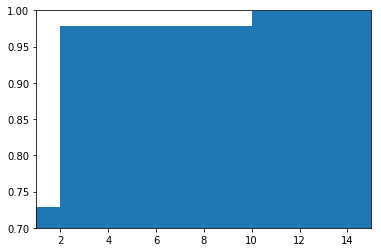

In [38]:
edges_officer_to_entity = edges_completed[mask_officer_to_entity]
entities_per_officer = edges_officer_to_entity['START_ID'].value_counts()

plt.xlim(1, 15)
plt.ylim(0.7, 1)
#plt.xscale('log')
plt.hist(entities_per_officer, bins=[1, 2, 10, 100, 1000, 10000, 100000], cumulative = True, density=True)

In [39]:
total_officers = len(entities_per_officer)

pourcentage_one_account = len(entities_per_officer[entities_per_officer == 1]) / total_officers * 100
pourcentage_two_account = len(entities_per_officer[entities_per_officer <= 2]) / total_officers * 100
pourcentage_ten_account = len(entities_per_officer[entities_per_officer <= 10]) / total_officers * 100


print(entities_per_officer.mean())
print('%.2f%% of officer are related to only one account' % pourcentage_one_account)
print('%.2f%% of officer are related to two or less account' % pourcentage_two_account)
print('%.2f%% of officer are related to ten or less account' % pourcentage_ten_account)

2.31727254666876
72.81% of officer are related to only one account
85.41% of officer are related to two or less account
98.21% of officer are related to ten or less account


### *5) Is there a correlation between the location of the people and the location of their offshore society?*

In [40]:
edges_diff_start_end_address = edges_completed[mask_country_notna & mask_diff_start_end_address]\
.end_type.value_counts()

In [138]:
edges_q5 = edges_completed[mask_officer_to_entity & mask_start_loc_notna & mask_end_loc_notna][['start_country', 'end_jurisdiction']]
edges_q5['sum'] = 1
edges_q5.start_country = edges_q5.start_country.str.split(';')

In [148]:
flattened_country = []

for index, row in edges_q5[(edges_q5.start_country.map(len) > 1)].iterrows():
    for country in row['start_country']:
        modified_row = row.copy()
        modified_row['start_country'] = country + '_GRP'
        flattened_country.append(modified_row)

edges_q5_flattened = edges_q5[edges_q5['start_country'].map(len) == 1]
edges_q5_flattened.start_country = edges_q5_flattened.start_country.apply(lambda arr: arr[0])
edges_q5_flattened = edges_q5_flattened.append(flattened_country)
      
print(len(edges_q5))
print(len(edges_q5_flattened))

1193002
1598918


In [167]:
q5_distrib = edges_q5_flattened.groupby(['start_country', 'end_jurisdiction']).sum()

## Q5 Pie printing

In [225]:
threshold_pourcentage = 0.05

def my_autopct(pct):
    """
    Only print pct if it is more than threshold
    """
    return ('%1.1f%%' % pct) if pct > 100*threshold_pourcentage else ''

def my_labels(serie):
    """
    Label is the jurisdiction name except if it's lower than threshold then it's ''
    """
    total = serie.sum().values[0]
    return [jurisdictions[row[0]] if row[1].values/total > 0.05 else '' for row in serie.iterrows()]

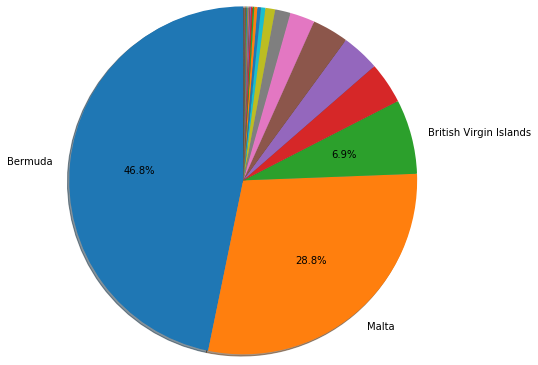

In [290]:
one_pie = q5_distrib.xs('GBR', level='start_country').sort_values('sum', ascending = False)
labels = my_labels(one_pie)

plt.pie(one_pie, radius = 2, labels=labels, autopct=my_autopct, startangle=90, shadow = True)
plt.show()

## Q5 Scatter

In [287]:
q5_distrib_country = q5_distrib.groupby('start_country').sum()
q5_distrib_country = q5_distrib.join(q5_distrib_country, how = 'left', on = 'start_country', rsuffix = '_country')
q5_distrib_country['pourcentage'] = q5_distrib_country['sum']/q5_distrib_country['sum_country']
q5_distrib_country.groupby('start_country').count()

sum  sum_country  pourcentage
start_country                               
ABW              7            7            7
AFG              2            2            2
AGO             10           10           10
AIA             17           17           17
ALB              8            8            8
AND             12           12           12
ARE             24           24           24
ARG             20           20           20
ARM              9            9            9
ASM              4            4            4
ATF              1            1            1
ATG              9            9            9
AUS             26           26           26
AUT             18           18           18
AZE             10           10           10
BDI              1            1            1
BEL             24           24           24
BEN              5            5            5
BFA              2            2            2
BGD              7            7            7
BGR             13           13           13
BHR             16           16           16
BHS             22           22           22
BIH              5            5            5
BLM              1            1            1
BLR              9            9            9
BLZ             20           20           20
BMU             31           31           31
BOL              9            9            9
BRA             22           22           22
...            ...          ...          ...
TCD              7            7            7
TGO              3            3            3
THA             23           23           23
TJK              3            3            3
TKM              3            3            3
TON              5            5            5
TTO             11           11           11
TUN              8            8            8
TUR             23           23           23
TUV              1            1            1
TWN             26           26           26
TZA              9            9            9
UGA              5            5            5
UKR             17           17           17
UMI              1            1            1
URY             19           19           19
USA             48           48           48
UZB              7            7            7
VCT             12           12           12
VEN             19           19           19
VGB             41           41           41
VIR             13           13           13
VNM             12           12           12
VUT              7            7            7
WSM             19           19           19
XXX             16           16           16
YEM              8            8            8
ZAF             21           21           21
ZMB              9            9            9
ZWE             11           11           11

[222 rows x 3 columns]

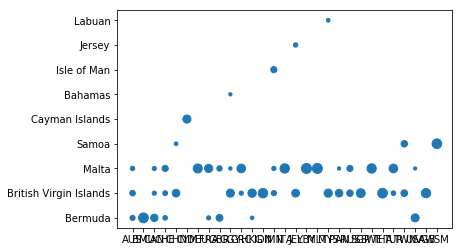

In [291]:
threshold_scatter_pourc = 0.1
threshold_scatter_countries = 10000

threshold_mask = (q5_distrib_country['pourcentage'] > threshold_scatter_pourc) \
& (q5_distrib_country['sum_country'] > threshold_scatter_countries)

q5_thresholded = q5_distrib_country[threshold_mask]

countries_x_scatter =  [val[0] for val in q5_thresholded.index.values]
jurisdictions_y_scatter =  [jurisdictions[val[1]] for val in q5_thresholded.index.values]
scalars_scatter = q5_thresholded['pourcentage'].values * 100

plt.scatter(countries_x_scatter, jurisdictions_y_scatter, scalars_scatter)
plt.show()

We can clearly see Malta and the British Virgin Islands as constant prefered choice whatever the country of origin of the officer.

### UP cell : now plot distribution for each country and see if there is always a leader, what is the variance, %of total for top1, BUILD MAP Where you can click on a country and see the distribution

In [44]:
edges_completed[(edges_completed['start_jurisdiction'] != edges_completed['end_jurisdiction']) \
               & (edges_completed['start_jurisdiction'].notna()) & ((edges_completed['end_jurisdiction'].notna()))]\
.TYPE.value_counts()

registered_address    79
officer_of             3
Name: TYPE, dtype: int64

## Create a dataframe of connected components ??

Study the type of START nodes and of END nodes to see if there is a logic (entity always START node etc...)

Should we consider the ones not leading to entity as outliers and withdraw them ?

## TODO : column link is more precise (shareholder of) just not there in bahamas
## Should be added with NaN if not there

## Analysis of start/end nodes

In [45]:
mask_start_node = nodes.index.get_level_values(0).isin(start_nodes)
mask_end_node = nodes.index.get_level_values(0).isin(end_nodes)

start_nodes_type = nodes[mask_start_node].index.get_level_values("type").tolist()
end_nodes_type = nodes[mask_end_node].index.get_level_values("type").tolist()

In [46]:
pd.Series(start_nodes_type).value_counts()

officer         720712
entity          306588
intermediary     25709
address              5
dtype: int64

So Address is (almost) never an end node (makes sense condsidering the name of edge is "address of")

In [47]:
pd.Series(end_nodes_type).value_counts()

entity          767724
address         374939
officer          80979
intermediary        66
dtype: int64

So intermediary is (almost) never an end node

Entity is the only node type to have jurisdiction, we need to link every entity with the other nodes that do contain a country_code. Let's see first if connected components always have the one country_code, and if not quantify it.

In [48]:
edges_officer_to_entity[edges_officer_to_entity['TYPE'] == 'officer_of']

START_ID    END_ID        TYPE start_date   end_date    source  \
192162   22013341  20000132  officer_of        NaT        NaT   bahamas   
192163   22017206  20000132  officer_of        NaT        NaT   bahamas   
192164   22023260  20000132  officer_of        NaT        NaT   bahamas   
192174   22006231  20000133  officer_of        NaT        NaT   bahamas   
192179   22012516  20000133  officer_of        NaT        NaT   bahamas   
192180   22014669  20000133  officer_of        NaT        NaT   bahamas   
192181   22016266  20000232  officer_of 2001-11-10        NaT   bahamas   
192182   22011010  20000401  officer_of 1990-03-20 2015-07-10   bahamas   
192183   22012900  20000401  officer_of 1990-03-20        NaT   bahamas   
192184   22017430  20000401  officer_of 1990-03-20        NaT   bahamas   
192185   22001592  20006756  officer_of 2015-10-07        NaT   bahamas   
192186   22001592  20000401  officer_of 2015-10-07        NaT   bahamas   
192187   22001592  20053821  officer_of 2015-10-07        NaT   bahamas   
192188   22021192  20002072  officer_of        NaT        NaT   bahamas   
192221   22010436  20002072  officer_of        NaT        NaT   bahamas   
192223   22006123  20002072  officer_of        NaT        NaT   bahamas   
192228   22022472  20002072  officer_of        NaT        NaT   bahamas   
192229   22000022  20121980  officer_of 2003-03-14        NaT   bahamas   
192230   22000022  20105651  officer_of 2003-03-14 2011-12-13   bahamas   
192231   22000022  20119287  officer_of 2003-03-14        NaT   bahamas   
192232   22000022  20118460  officer_of 2003-03-14        NaT   bahamas   
192233   22000022  20062794  officer_of 2003-03-14 2013-10-02   bahamas   
192234   22000022  20054595  officer_of 2003-03-14 2010-11-04   bahamas   
192235   22000022  20042685  officer_of 2003-03-14 2012-01-18   bahamas   
192236   22000022  20039445  officer_of 2003-03-14        NaT   bahamas   
192237   22000022  20074235  officer_of 2003-03-14 2012-02-28   bahamas   
192238   22000022  20081722  officer_of 2003-03-14        NaT   bahamas   
192239   22000022  20000359  officer_of 2003-03-14        NaT   bahamas   
192240   22000022  20002181  officer_of 2003-03-14        NaT   bahamas   
192241   22000022  20002187  officer_of 2003-03-14 2011-10-20   bahamas   
...           ...       ...         ...        ...        ...       ...   
3090282     70913    153575  officer_of 2007-03-28        NaT  offshore   
3090283     70913    153575  officer_of 2007-03-28        NaT  offshore   
3090285     70914    165267  officer_of 2008-02-20        NaT  offshore   
3090286     70914    165267  officer_of 2008-02-20        NaT  offshore   
3090288     70915    158680  officer_of 2008-05-14        NaT  offshore   
3090289    103460    151256  officer_of 2006-08-01        NaT  offshore   
3090290    103460    151256  officer_of 2006-08-01        NaT  offshore   
3090291    103466    148316  officer_of 2005-12-22 2007-05-23  offshore   
3090292    103470    130596  officer_of 2001-08-03 2003-02-21  offshore   
3090293    103475    132481  officer_of 2002-07-18        NaT  offshore   
3090294    103475    132481  officer_of 2002-07-18        NaT  offshore   
3090295    103479    129886  officer_of 2004-11-18        NaT  offshore   
3090297     70916    171274  officer_of 2002-03-26        NaT  offshore   
3090299     70917    165393  officer_of 2008-04-02        NaT  offshore   
3090301     70918    146116  officer_of 2005-05-31        NaT  offshore   
3090303     70920    150626  officer_of 2006-07-13        NaT  offshore   
3090304     70920    150040  officer_of 2006-06-22        NaT  offshore   
3090306     70921    142035  officer_of 2004-05-18        NaT  offshore   
3090307     70921    142035  officer_of 2004-05-18        NaT  offshore   
3090309     70922    146934  officer_of 2005-11-07        NaT  offshore   
3090311     70923    143016  officer_of 2006-10-26        NaT  offshore   
3090313     70924    152761  offic

Use slicers to access a set of values on index